In [5]:
from pymongo import MongoClient
import certifi
import os
from dotenv import load_dotenv
from utils.translation import translate_text
from utils.courses import find_courses_by_name, retrieve_lessons_text, get_google_translations_from_txt, encode_course_by_lesson 
import pandas as pd
from functools import partial, reduce
from random import randint

In [6]:
#Load env variables
load_dotenv()
MONGO_URI = os.environ["MONGO_DB_URI"]
PATH = os.environ["DIR_PATH"]

In [7]:
#Load the gcf data from the MongoDB db
ca = certifi.where()
cluster = MongoClient(host=MONGO_URI, tlsCAFile=ca)
db = cluster["gcfglobal"]
collection_lessons = db["lesson"]
collection_tutorials = db['tutorial']

# Build a dictionary with all the courses lessons

- Additionally, we generate colors for each course

In [8]:
paths = [
    ('como-usar-o-twitter', 'como-usar-twitter'),
    ('excel-2016',), 
    # ('microsoft-excel-2010',), 
    ('microsoft-word-2010',), 
    ('powerpoint-2019',), 
    ('word-2016',),
    ('algebra',), 
    ('credito',), 
    ('curso-de-fotografia-digital',), 
    ('curso-de-photoshop',), 
    ('informatica-basica',),
    ('whatsapp-business',), 
    ('virus-e-antivirus','virus-informaticos-y-antivirus'),
    ('criacao-de-sites','creacion-de-sitios-web'),
    ('seguranca-na-internet', 'seguridad-en-internet'),
    ('criar-um-correio-eletronico', 'crear-un-correo-electronico'),
    ('como-criar-um-blog', 'crear-un-blog-en-internet'),
    ('apresentacoes-basicas', 'presentaciones-basicas'),
    ('como-usar-o-telegram', 'curso-de-telegram'),
    ('tudo-sobre-o-windows-10', 'como-usar-windows-10'),
    ('como-usar-o-sistema-android', 'como-usar-android'),
    ('criar-uma-conta-no-facebook', 'crear-cuenta-en-facebook'),
    ('aplicativos', 'aplicaciones'),
    ('google-sala-de-aula-para-alunos', 'google-classroom-para-estudiantes'),
    ('somar-e-subtrair', 'sumar-y-restar'),
    ('como-fazer-multiplicacao', 'multiplicar'),
    ('divisao', 'dividir'),
    ('multiplos-e-divisores', 'divisores-y-multiplos'),
    ('numeros-fracionarios', 'fraccionarios'),
    ('os-numeros-decimais', 'los-decimales'),
    ('os-conjuntos-matematicos', 'los-conjuntos'),
    ('usando-a-matematica', 'aplicaciones-de-la-matematica'),
    ('conceitos-basicos-da-matematica', 'temas-basicos'),
    ('empreendedorismo', 'emprendimiento'),
    # ('criatividade','creatividad'),
    ('os-caminhos-da-graduacao', 'acceso-a-la-educacion-superior'),
    ('credito',),
    ('conceitos-basicos-de-design-grafico', 'conceptos-basicos-de-diseno-grafico'),
]

In [9]:
f = partial(find_courses_by_name, collection_tutorials)
g = (lambda x: retrieve_lessons_text(collection_lessons, f(x)))

In [10]:
complete_lessons = reduce(lambda x,y: x | y, map(g,paths), dict()) 

Found 1 tutorials for course como-usar-o-twitter 

Found 1 tutorials for course como-usar-twitter 

Found 2 tutorials for course excel-2016 

Found 2 tutorials for course microsoft-word-2010 

Found 2 tutorials for course powerpoint-2019 

Found 2 tutorials for course word-2016 

Found 2 tutorials for course algebra 

Found 2 tutorials for course credito 

Found 2 tutorials for course curso-de-fotografia-digital 

Found 2 tutorials for course curso-de-photoshop 

Found 2 tutorials for course informatica-basica 

Found 2 tutorials for course whatsapp-business 

Found 1 tutorials for course virus-e-antivirus 

Found 1 tutorials for course virus-informaticos-y-antivirus 

Found 1 tutorials for course criacao-de-sites 

Found 1 tutorials for course creacion-de-sitios-web 

Found 1 tutorials for course seguranca-na-internet 

Found 1 tutorials for course seguridad-en-internet 

Found 1 tutorials for course criar-um-correio-eletronico 

Found 1 tutorials for course crear-un-correo-electronic

In [11]:
courses = list(complete_lessons.keys())

In [12]:
def listdirs(path):
    return [d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]

# Get encodings (lesson level) with Google Translate Text Included

In [13]:
h = partial(get_google_translations_from_txt, 'C:/Users/Usuario/Desktop/monitoria/analisis_traducciones/data/translate')
google_translations = list(zip(courses,(map(lambda x: h(x,complete_lessons), courses))))

In [14]:
complete_lessons_encodings = reduce(lambda x, y: x | y, map(lambda x: encode_course_by_lesson(complete_lessons, x[0],'multi-qa-distilbert-cos-v1',x[1]),google_translations), dict())

# PCA for each of the encodings

In [15]:
from utils.courses import keys_to_tuple
import numpy as np

In [16]:
total_encodings = np.concatenate(list(map(lambda x: complete_lessons_encodings[x[0]][x[1]], keys_to_tuple(complete_lessons_encodings))))

In [17]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

pca = PCA(n_components = 2)
pca2 = PCA(n_components = 3)
pca.fit(total_encodings)
pca2.fit(total_encodings)
tsne = TSNE(2,perplexity=2)
tsne.fit(total_encodings)



TSNE(perplexity=2)

In [18]:
pca_vectors = list(map(lambda x: ((x[0],x[1]),pca.transform(complete_lessons_encodings[x[0]][x[1]])), keys_to_tuple(complete_lessons_encodings)))
pca2_vectors = list(map(lambda x: ((x[0],x[1]),pca2.transform(complete_lessons_encodings[x[0]][x[1]])), keys_to_tuple(complete_lessons_encodings)))
tsne_vectors = list(map(lambda x: ((x[0],x[1]),tsne.fit_transform(complete_lessons_encodings[x[0]][x[1]])), keys_to_tuple(complete_lessons_encodings)))

In [19]:
import pickle as pkl

with open('pca_vectors.pickle', 'wb') as handle:
    pkl.dump(pca_vectors, handle, protocol=pkl.HIGHEST_PROTOCOL)

# Gráfica por Curso (nivel de lesson)

In [20]:
from colour import Color

In [21]:
import random
def generate_colors(courses: list,colors=[]):
    if len(colors) == len(courses):
        return colors
    else:
        r = round(random.uniform(0,1),2)
        g = round(random.uniform(0,1),2)
        b = round(random.uniform(0,1),2)
        return generate_colors(courses, [*colors, Color(rgb=(r,g,b)).get_hex_l()])

In [22]:
print(courses)

['como-usar-o-twitter', 'excel-2016', 'microsoft-word-2010', 'powerpoint-2019', 'word-2016', 'algebra', 'credito', 'curso-de-fotografia-digital', 'curso-de-photoshop', 'informatica-basica', 'whatsapp-business', 'virus-e-antivirus', 'criacao-de-sites', 'seguranca-na-internet', 'criar-um-correio-eletronico', 'como-criar-um-blog', 'apresentacoes-basicas', 'como-usar-o-telegram', 'tudo-sobre-o-windows-10', 'como-usar-o-sistema-android', 'criar-uma-conta-no-facebook', 'aplicativos', 'google-sala-de-aula-para-alunos', 'somar-e-subtrair', 'como-fazer-multiplicacao', 'divisao', 'multiplos-e-divisores', 'numeros-fracionarios', 'os-numeros-decimais', 'os-conjuntos-matematicos', 'usando-a-matematica', 'conceitos-basicos-da-matematica', 'empreendedorismo', 'os-caminhos-da-graduacao', 'conceitos-basicos-de-design-grafico']


In [23]:
colors_for_course = list(zip(courses,generate_colors(courses)))
colors_for_course2 = list(zip(courses,generate_colors(courses)))

In [24]:
colors_dict = dict(colors_for_course)

In [25]:
colors_dicts2 = dict(colors_for_course2)

In [26]:
print(colors_dict)

{'como-usar-o-twitter': '#b5bd21', 'excel-2016': '#260d4c', 'microsoft-word-2010': '#8f6e66', 'powerpoint-2019': '#19a34c', 'word-2016': '#03a80d', 'algebra': '#4ce538', 'credito': '#a62426', 'curso-de-fotografia-digital': '#73d9b8', 'curso-de-photoshop': '#ebf09e', 'informatica-basica': '#5203c4', 'whatsapp-business': '#177ab2', 'virus-e-antivirus': '#bf7ab2', 'criacao-de-sites': '#8c4c82', 'seguranca-na-internet': '#ad9999', 'criar-um-correio-eletronico': '#a329b2', 'como-criar-um-blog': '#873645', 'apresentacoes-basicas': '#9163e8', 'como-usar-o-telegram': '#d49c59', 'tudo-sobre-o-windows-10': '#0573b5', 'como-usar-o-sistema-android': '#e0eb12', 'criar-uma-conta-no-facebook': '#ad7317', 'aplicativos': '#2e2438', 'google-sala-de-aula-para-alunos': '#eb26fc', 'somar-e-subtrair': '#879c3d', 'como-fazer-multiplicacao': '#cff775', 'divisao': '#381ce5', 'multiplos-e-divisores': '#30147d', 'numeros-fracionarios': '#ba8214', 'os-numeros-decimais': '#00a15e', 'os-conjuntos-matematicos': '#db

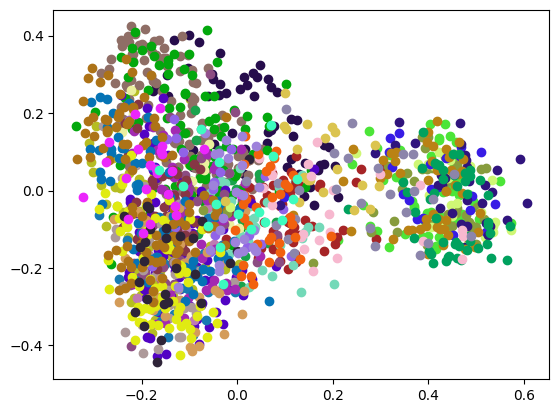

In [27]:
import matplotlib.pyplot as plt
i = 0
for (course_name, language), vectors in pca_vectors:
    if language == 'google':
        continue
    # print(course_name)
    # print(language)
    x = list(map(lambda x: x[0], vectors))
    y = list(map(lambda x: x[1], vectors))
    plt.scatter(x, y, color=colors_dict[course_name])
    # if language == 'pt':
    #     plt.scatter(x, y, color=colors_dict[course_name])
    # if language == 'es':
    #     plt.scatter(x, y, color=colors_dicts2[course_name])
    # if i > 4:
    #     break
    # i +=1


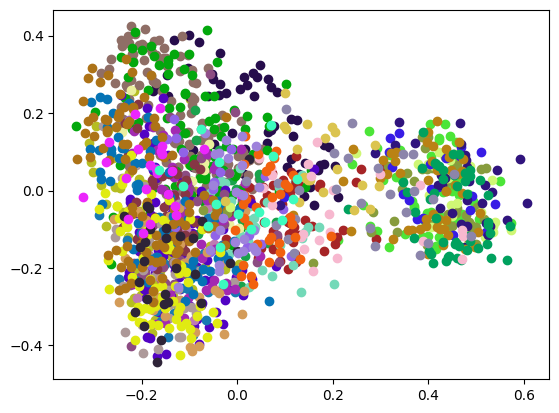

In [28]:
i = 0
for (course_name, language), vectors in pca2_vectors:
    if language == 'google':
        continue
    # print(course_name)
    # print(language)
    x = list(map(lambda x: x[0], vectors))
    y = list(map(lambda x: x[1], vectors))
    z = list(map(lambda x: x[2], vectors))
    plt.scatter(x, y, color=colors_dict[course_name])

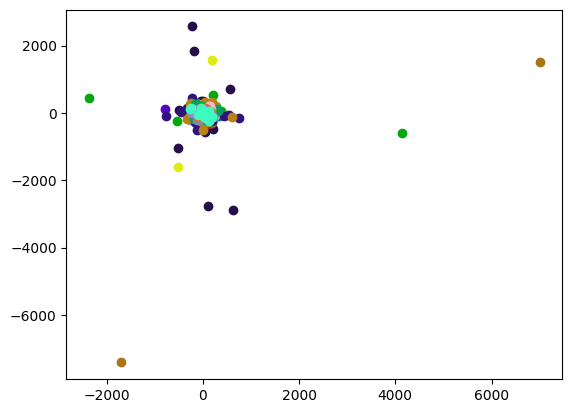

In [29]:
import matplotlib.pyplot as plt
i = 0
for (course_name, language), vectors in tsne_vectors:
    if language == 'google':
        continue
    # print(course_name)
    # print(language)
    x = list(map(lambda x: x[0], vectors))
    y = list(map(lambda x: x[1], vectors))
    plt.scatter(x, y, color=colors_dict[course_name])

# Graficar por lenguaje

In [30]:
language_color_dict = {'es': '#FF0000', 'pt': '#0000FF', 'google': '#00FF00'}
#Verde: Google
#Rojo: Español
#Azul: Portugues

In [31]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

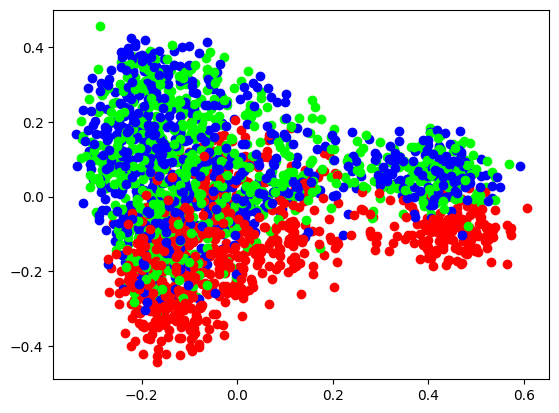

In [32]:
for (course_name, language), vectors in pca_vectors:
    x = list(map(lambda x: x[0], vectors))
    y = list(map(lambda x: x[1], vectors))
    plt.scatter(x, y, color=language_color_dict[language])

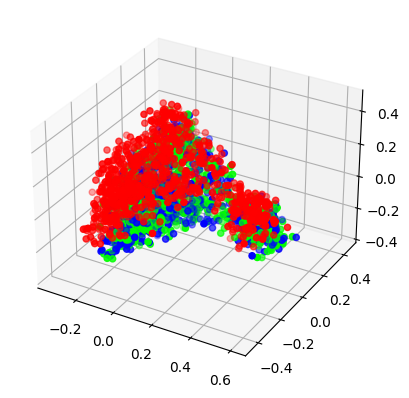

In [33]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for (course_name, language), vectors in pca2_vectors:
    x = list(map(lambda x: x[0], vectors))
    y = list(map(lambda x: x[1], vectors))
    z = list(map(lambda x: x[2], vectors))
    ax.scatter(x, y,z, color=language_color_dict[language])


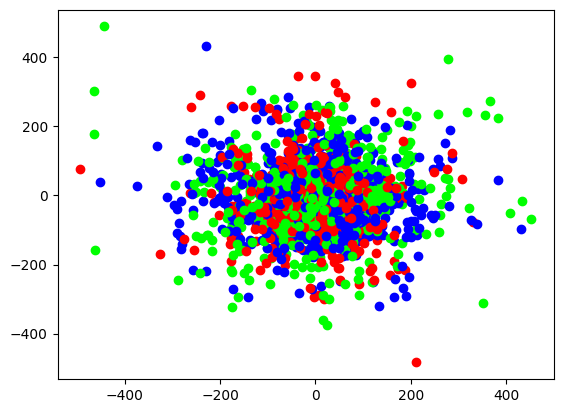

In [34]:
for (course_name, language), vectors in tsne_vectors:
    x = list(map(lambda x: x[0], vectors))
    y = list(map(lambda x: x[1], vectors))
    xs = []
    ys = []
    for i in range(len(x)):
        if x[i]>-500 and x[i] <500 and y[i]>-500 and y[i] <500:
            xs.append(x[i])
            ys.append(y[i])
    plt.scatter(xs, ys, color=language_color_dict[language])